In [27]:
# !pip install gensim==3.8.3

# Khai báo các thư viện sử dụng

In [28]:
import nltk
import tensorflow as tf
import json
import pandas as pd
import numpy as np
from tqdm import tqdm
from keras.preprocessing.text import Tokenizer
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from gensim.models.doc2vec import TaggedDocument
import re
import matplotlib.pyplot as plt
import pickle
from sklearn import utils
#nltk.download()

In [29]:
#import keras
#import tensorflow as tf
#import gensim

#print("gensum:", gensim.__version__)
#print("Keras version:", keras.__version__)
#print("TensorFlow version:", tf.__version__)

In [30]:
#import sys
#!{sys.executable} -m pip install tensorflow

Đường dẫn đến folder chứa project

In [31]:
origin_path = 'C:/Data Science/CHATBOT_DTU_Bi_LSTM'

In [32]:
# Khai báo từ điển để chuyển tiếng việt CÓ dấu về tiếng việt KHÔNG dấu 
patterns = {
    '[àáảãạăắằẵặẳâầấậẫẩ]': 'a',
    '[đ]': 'd',
    '[èéẻẽẹêềếểễệ]': 'e',
    '[ìíỉĩị]': 'i',
    '[òóỏõọôồốổỗộơờớởỡợ]': 'o',
    '[ùúủũụưừứửữự]': 'u',
    '[ỳýỷỹỵ]': 'y'
}
# Khai báo các ký tự đặc biệt để loại bỏ
special_character = r'[!“”"#$%&\'()*+,-./:;<=>?@[\]^_`{|}~]'

# Khai báo danh sách các từ cần loại bỏ
stop_words = ['bạn', 'ban', 'anh', 'chị', 'chi', 'em', 'shop', 'bot', 'ad', 'là', 'có', 'và', 'hoặc', 'nếu', 'vậy', 'thế', 'còn']

# Hàm làm sạch các ký tự, chuyển thành tiếng việt không dấu và chuyển chữ thành chữ thường
def convert_to_no_accents(text):
    output = text
    for regex, replace in patterns.items():
        output = re.sub(regex, replace, output)
        output = re.sub(regex.upper(), replace.upper(), output)
        output = re.sub(special_character, '', output)
        output = output.lower()
    return output

Lấy dữ liệu đọc từ file JSON

In [33]:
trains = {}
# response = {}
with open(f'{origin_path}/data/chatbot_dataset_CMU.json', 'r', encoding='utf-8') as json_data:
    intents = json.load(json_data)
    for one_intent in intents['intents']:
        sentences = one_intent['patterns']
        trains[one_intent['tag']] = sentences
        # response[one_intent['tag']] = one_intent['responses']

Làm sạch dữ liệu và gán nhãn tương ứng

In [34]:
classes = {}
X_dev = []
y_dev = []
for i, (key, value) in enumerate(trains.items()):
    X_dev += [convert_to_no_accents(v) for v in value]
    y_dev += [i] * len(value) 
    classes[i] = key
    

Lưu danh sách class name

In [35]:
pickle.dump(classes, open(f"{origin_path}/model/classes.pkl", "wb"))
classes

{0: 'Cách để đánh giá rèn luyện trên mydtu',
 1: 'Khi nào mở lại đánh giá rèn luyện vậy ?',
 2: 'Chuyện gì xảy ra khi không đánh giá điểm rèn luyện ?',
 3: 'Không khai báo ngoại trú đánh giá điểm rèn luyện được không ?',
 4: 'Khi nào mở khai báo ngoại trú ?',
 5: 'Tích lũy điểm là gì?',
 6: 'Cách để cải thiện điểm rèn luyện ?',
 7: 'Cách khai báo ngoại trú ?',
 8: 'Đánh giá giảng viên bằng cách nào ?',
 9: 'Khám sức khỏe bận có thể khám chung lớp khác được không ?',
 10: 'Có cần phải mặc áo trường quốc tế khi học không thầy?',
 11: 'BHYT nộp ở đâu ?',
 12: 'Quy định và quy chế về gian lận trong phòng thi',
 13: 'Mua sách giáo khoa ở đâu ?',
 14: 'Cách liên hệ giảng viên cố vấn',
 15: 'Tìm phòng học theo ký hiệu trong thời khóa biểu như thế nào?',
 16: 'Mất đồ bây giờ làm sao ?',
 17: 'Thời gian mở xét tuyển là khi nào?',
 18: 'Cách nộp bài tập về nhà trên assiment?',
 19: 'Các thông tin khác ?',
 20: 'Điều kiện và cách làm đơn phúc khảo bài thi?',
 21: 'Điều kiện và cách làm giấy tạm h

Chuyển dữ liệu về dạng Data Frame

In [36]:
df = pd.DataFrame({'question': X_dev, "category": y_dev})
df

,question,category
0,huong dan danh gia ren luyen tren mydtu,0
1,can lam nhung gi de danh gia ren luyen tren mydtu,0
2,cac buoc de danh gia ren luyen tren mydtu,0
3,danh gia ren luyen tren mydtu sao cho dung,0
4,co phuong phap cu the nao de danh gia diem ren...,0
...,...,...
3542,lam sao de dung chatbot,180
3543,bye nha,181
3544,tam biet,181
3545,hen gap lai,181


In [37]:
num_class = len(list(set(df['category'].to_list())))
num_class

182

Chia dữ liệu huấn luyện, đánh giá

In [38]:
train, test = train_test_split(df, test_size=0.05 , random_state=42)

In [39]:
# Nhận một đoạn văn bản làm đầu vào và trả về danh sách các từ đã được "tokenized"
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) <= 0:
                continue
            tokens.append(word.lower())
    return tokens
train_tagged = train.apply(lambda r: TaggedDocument(words=tokenize_text(r['question']), tags=[r.category]), axis=1)
test_tagged = test.apply(lambda r: TaggedDocument(words=tokenize_text(r['question']), tags=[r.category]), axis=1)

In [40]:
    max_fatures = 150 # Số lượng features tối đa
    MAX_SEQUENCE_LENGTH = 50 # Số lượng từ tối đa

In [41]:
# khởi tạo một tokenizer với các cấu hình được sử dụng để tokenize các văn bản
tokenizer = Tokenizer(num_words=max_fatures, split=' ', lower=True)

In [42]:
tokenizer.fit_on_texts(df['question'].values)

In [43]:
# Lưu tokenizer
with open(f"{origin_path}/model/tokenizer.pkl", 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [44]:
# # Tải tokenizer
# with open(f"{origin_path}/model/tokenizer.pkl", 'rb') as handle:
#     loaded_tokenizer = pickle.load(handle)

In [45]:
# Chuyển đổi các văn bản thành các chuỗi các chỉ mục tương ứng trong từ điển
X = tokenizer.texts_to_sequences(df['question'].values)
X = pad_sequences(X)
print('Found %s unique tokens.' % len(X))

Found 3547 unique tokens.


In [46]:
# Tạo và huấn luyện một mô hình "Doc2Vec" (Word Embedding) 
d2v_model = Doc2Vec(dm=1, dm_mean=1, window=8, min_count=1, workers=1, alpha=0.065, min_alpha=0.065)
d2v_model.build_vocab([x for x in tqdm(train_tagged.values)])

100%|██████████| 3369/3369 [00:00<?, ?it/s]


In [47]:
# Huấn luyện mô hình Doc2Vec trong 30 epochs
for epoch in range(30):
    d2v_model.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    d2v_model.alpha -= 0.002
    d2v_model.min_alpha = d2v_model.alpha

100%|██████████| 3369/3369 [00:00<?, ?it/s]


In [48]:
print(d2v_model)

Doc2Vec(dm/m,d100,n5,w8,s0.001)


In [49]:
# Tạo ra ma trận nhúng (embedding matrix) cho các văn bản trong mô hình Doc2Vec 
embedding_matrix = np.zeros((len(d2v_model.wv.vocab)+ 1, 20))

for i, vec in enumerate(d2v_model.docvecs.vectors_docs):
    while i in vec <= 1000:
        embedding_matrix[i]=vec


Xây dựng mô hình Bi-LSTM 

In [50]:
from keras.models import Sequential
from keras.layers import Bidirectional, LSTM, Dense, Embedding

# Khởi tạo lớp
model = Sequential()

# Nhúng vector từ
model.add(Embedding(len(d2v_model.wv.vocab) + 1, 20, input_length=X.shape[1], weights=[embedding_matrix], trainable=True))

# Học các mối tương quan
def split_input(sequence):
    return sequence[:-1], tf.reshape(sequence[1:], (-1, 1))

# Thay thế LSTM thành Bi-LSTM
model.add(Bidirectional(LSTM(50, return_sequences=False)))

model.add(Dense(num_class, activation="softmax"))

# Cấu trúc mô hình
model.summary()
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['acc'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 40, 20)            15840     
                                                                 
 bidirectional_1 (Bidirecti  (None, 100)               28400     
 onal)                                                           
                                                                 
 dense_1 (Dense)             (None, 182)               18382     
                                                                 
Total params: 62622 (244.62 KB)
Trainable params: 62622 (244.62 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [51]:
# Tạo ra một DataFrame mới, trong đó mỗi giá trị của biến phân loại sẽ được chuyển thành một vector nhị phân, với giá trị 1 tại vị trí của lớp và 0 ở những vị trí còn lại
Y = pd.get_dummies(df['category']).values
print(X.shape,Y.shape)

(3547, 40) (3547, 182)


In [52]:
# Huấn luyện mô hình
batch_size = 4
history=model.fit(X, Y, epochs =200, batch_size=batch_size, verbose = 2, validation_data = (X, Y))

Epoch 1/200
887/887 - 11s - loss: 4.9586 - acc: 0.0248 - val_loss: 4.4841 - val_acc: 0.0688 - 11s/epoch - 13ms/step
Epoch 2/200
887/887 - 9s - loss: 4.1854 - acc: 0.0961 - val_loss: 3.7744 - val_acc: 0.1508 - 9s/epoch - 10ms/step
Epoch 3/200
887/887 - 9s - loss: 3.6563 - acc: 0.1618 - val_loss: 3.3435 - val_acc: 0.2222 - 9s/epoch - 10ms/step
Epoch 4/200
887/887 - 9s - loss: 3.3275 - acc: 0.2047 - val_loss: 3.0711 - val_acc: 0.2771 - 9s/epoch - 10ms/step
Epoch 5/200
887/887 - 9s - loss: 3.0666 - acc: 0.2715 - val_loss: 2.8293 - val_acc: 0.3152 - 9s/epoch - 10ms/step
Epoch 6/200
887/887 - 15s - loss: 2.8445 - acc: 0.3101 - val_loss: 2.6474 - val_acc: 0.3502 - 15s/epoch - 17ms/step
Epoch 7/200
887/887 - 9s - loss: 2.6443 - acc: 0.3583 - val_loss: 2.4099 - val_acc: 0.4251 - 9s/epoch - 10ms/step
Epoch 8/200
887/887 - 9s - loss: 2.4660 - acc: 0.3989 - val_loss: 2.2628 - val_acc: 0.4559 - 9s/epoch - 10ms/step
Epoch 9/200
887/887 - 9s - loss: 2.2854 - acc: 0.4373 - val_loss: 2.0845 - val_acc: 

In [53]:
# Lưu mô hình
model.save(f'{origin_path}/model/model.h5')

C:\Users\OS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [54]:
from keras.models import load_model

# # Tải mô hình
#loaded_model = load_model(f'{origin_path}/model/model.h5')

Kết quả huấn luyện trên tập huấn luyện

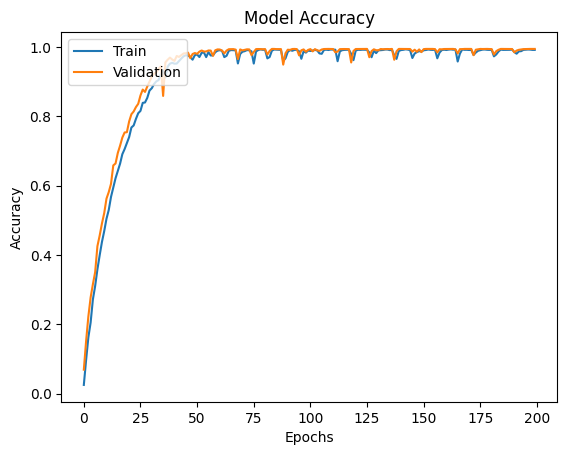

In [55]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])  # Thêm dòng này để vẽ biểu đồ cho độ chính xác trên tập validation
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'], loc='upper left')  # Sửa 'test' thành 'validation'
plt.show()

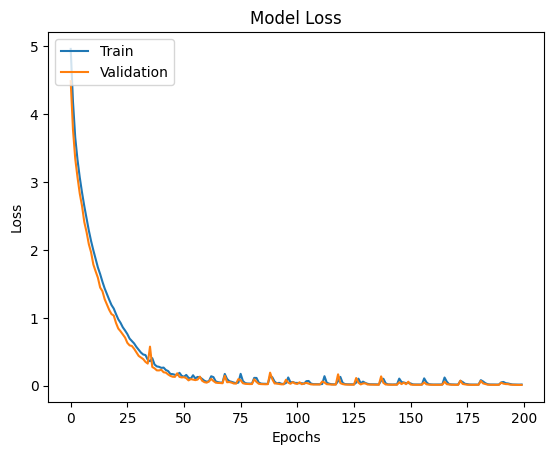

In [56]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])  # Thêm dòng này để vẽ biểu đồ cho giá trị mất mát trên tập validation
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'], loc='upper left')  # Sửa 'test' thành 'validation'
plt.show()

Dự đoán ==> Chatbot

In [57]:
classes = pickle.load(open(f"{origin_path}/model/classes.pkl", "rb"))

In [58]:
import random
def response(tag):
    for i in intents['intents']:
        if i['tag'] == tag:
            return random.choice(i['responses'])

In [59]:
message = ['Ai tạo chatbot']
message = convert_to_no_accents(message[0])

seq = tokenizer.texts_to_sequences([message])

padded = pad_sequences(seq, maxlen=40, dtype='int32', value=0)

pred = model.predict(padded)

# labels = range(0, 113, 1)
print(pred)
print(response(classes[np.argmax(pred)]))
print(" giá trị có xác xuất cao nhất")
print(classes[np.argmax(pred)])

1/1 [==============================] - 2s 2s/step
[[7.46123486e-13 2.07695880e-13 1.51278403e-08 1.12149428e-08
  2.81109713e-08 4.36481476e-11 7.96034245e-12 2.98966505e-08
  1.95449315e-13 1.52861492e-08 8.11705377e-06 4.94204460e-06
  2.18078600e-09 6.07138247e-07 4.19988384e-11 6.66938060e-09
  5.83338011e-13 3.41761219e-09 3.92114598e-05 2.84304188e-05
  1.24822014e-10 4.05428857e-10 1.05820970e-06 2.38980054e-08
  2.30961041e-06 2.72385012e-08 5.13329468e-08 3.52733664e-09
  1.11279856e-08 1.66025748e-05 3.56909179e-04 3.34415030e-11
  1.10031363e-06 8.59235261e-09 1.00867181e-08 3.25628524e-09
  8.21260571e-09 4.18031360e-10 9.94654492e-09 1.50506430e-09
  2.73498807e-10 2.59204921e-06 7.42214883e-12 4.34955316e-09
  2.29617179e-08 6.60921103e-07 1.71483521e-06 3.11014235e-11
  1.90604936e-08 1.83690216e-10 3.20057936e-08 1.78732023e-07
  2.47743437e-10 2.07195275e-10 1.44324352e-09 3.06224592e-07
  5.83164539e-09 3.41585937e-09 8.72404993e-09 2.66385869e-09
  1.09045419e-10 4.9

In [60]:
print(classes)
print(np.argmax(pred))

{0: 'Cách để đánh giá rèn luyện trên mydtu', 1: 'Khi nào mở lại đánh giá rèn luyện vậy ?', 2: 'Chuyện gì xảy ra khi không đánh giá điểm rèn luyện ?', 3: 'Không khai báo ngoại trú đánh giá điểm rèn luyện được không ?', 4: 'Khi nào mở khai báo ngoại trú ?', 5: 'Tích lũy điểm là gì?', 6: 'Cách để cải thiện điểm rèn luyện ?', 7: 'Cách khai báo ngoại trú ?', 8: 'Đánh giá giảng viên bằng cách nào ?', 9: 'Khám sức khỏe bận có thể khám chung lớp khác được không ?', 10: 'Có cần phải mặc áo trường quốc tế khi học không thầy?', 11: 'BHYT nộp ở đâu ?', 12: 'Quy định và quy chế về gian lận trong phòng thi', 13: 'Mua sách giáo khoa ở đâu ?', 14: 'Cách liên hệ giảng viên cố vấn', 15: 'Tìm phòng học theo ký hiệu trong thời khóa biểu như thế nào?', 16: 'Mất đồ bây giờ làm sao ?', 17: 'Thời gian mở xét tuyển là khi nào?', 18: 'Cách nộp bài tập về nhà trên assiment?', 19: 'Các thông tin khác ?', 20: 'Điều kiện và cách làm đơn phúc khảo bài thi?', 21: 'Điều kiện và cách làm giấy tạm hoãn nghĩa vụ quân sự?

random câu hỏi theo chủ đề để train dữ liệu